# Generating Maps of Cold Galactic Clumps from the Planck Galactic Cold Clump (PGCC) Catalogue
### We also will be reading in Planck GNILC maps and adding these Galactic Cold Clump maps to test the position/scale/orientation of the sources and see if they are present in the GNILC Maps.
### Finally we also have an example of scaling the frequency from the measured 353 GHz data in the PGCC catalogue to a new frequency to be used by SO (in this example 27 GHz) 

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from add_planck_galccs.generate_galcc_maps import build_galactic_clump_map
import pysm3.units as u
import pandas as pd
import mapsims
from pathlib import Path
from time import time
from astropy.io import fits
import numpy as np

# Read Planck Cold Galactic Clump Catalogue
df = pd.read_csv('PGCC.csv')
glons = df['glon']
glats = df['glat']
# Read GNILC maps: Frequencies {857, 545, 353 GHz}
GNILC_freq_folder = "/global/homes/j/justinc/Galactic Cold Clumps/Data/"
GNILC_freqdir = Path(GNILC_freq_folder)
gnilc_map_353, gh3 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits", h = True)
gnilc_map_545, gh5 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F545_2048_R2.00.fits", h = True)
gnilc_map_857, gh8 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F857_2048_R2.00.fits", h = True)
# Read GNILC maps: Temperature and Beta
GNILC_spectral_folder = "/global/project/projectdirs/cmb/www/pysm-data/dust_gnilc/"  # NERSC
GNILC_specdir = Path(GNILC_spectral_folder)
gnilc_dust_Td_nside2048, th = hp.read_map(GNILC_specdir / "gnilc_dust_Td_nside2048.fits", h = True)
gnilc_dust_Bd_nside2048, bh = hp.read_map(GNILC_specdir / "gnilc_dust_beta_nside2048.fits", h = True)

beamfile = fits.open(GNILC_freq_folder + "COM_CompMap_Dust-GNILC-Beam-FWHM_0128_R2.00.fits") # Variable Beam Map - Implementation ??

#### Generate Galactic Cold Clump maps at specified frequencies

In [2]:
# Create empty HEALPix map with given Nside
# Read source catalogue to get source properties and build empty map at given Nside
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")

# Generate Galactic Cold Clump maps at Planck measured frequencies
galccmap_353 = base_map.cold_clumps_flux(freq_out = 353, store_maps = False, output_units = u.MJy/u.sr)
galccmap_545 = base_map.cold_clumps_flux(freq_out = 545, store_maps = False, output_units = u.MJy/u.sr)
galccmap_857 = base_map.cold_clumps_flux(freq_out = 857, store_maps = False, output_units = u.MJy/u.sr)

# Generate Galactic Cold Clump maps of Temperature and Spectral Emissivity
galccmap_temp = base_map.cold_clumps_spectral(maptype = 'temp', store_maps = False)
galccmap_beta = base_map.cold_clumps_spectral(maptype = 'beta', store_maps = False)

In [3]:
Beam = False

# Choose if wanting to smooth GCC maps by Planck Beams
if Beam == True:
    "All Planck and IRIS maps have been convolved to 5' FWHM before performing source detection and extraction"     
    
    # Smooth Galactic Cold Clump maps by Planck beams
    galccmap_353 = hp.smoothing(galccmap_353, fwhm = (5 * u.arcmin).to_value(u.rad))
    galccmap_545 = hp.smoothing(galccmap_545, fwhm = (5 * u.arcmin).to_value(u.rad))
    galccmap_857 = hp.smoothing(galccmap_857, fwhm = (5 * u.arcmin).to_value(u.rad))

    galccmap_temp = hp.smoothing(galccmap_temp, fwhm = (5 * u.arcmin).to_value(u.rad))
    galccmap_beta = hp.smoothing(galccmap_beta, fwhm = (5 * u.arcmin).to_value(u.rad))

In [4]:
# Add Galactic Cold Clump Maps to Planck GNILC frequency, temperature and beta maps
combined_gnilcmap_353 = gnilc_map_353.copy()
combined_gnilcmap_545 = gnilc_map_545.copy()
combined_gnilcmap_857 = gnilc_map_857.copy()
combined_gnilcmap_353 += galccmap_353
combined_gnilcmap_545 += galccmap_545
combined_gnilcmap_857 += galccmap_857

combined_gnilcmap_temp = gnilc_dust_Td_nside2048.copy()
combined_gnilcmap_beta = gnilc_dust_Bd_nside2048.copy()
combined_gnilcmap_temp += galccmap_temp
combined_gnilcmap_beta += galccmap_beta

# Planck GNILC Maps (left) with added Planck Galactic Cold Clumps (right)
## Note the essentially 1-1 correlation between sources in the GNILC maps with the sources from PGCC catalogue generated maps
### Also note a difference in brightness, unsure still as to the cause of this

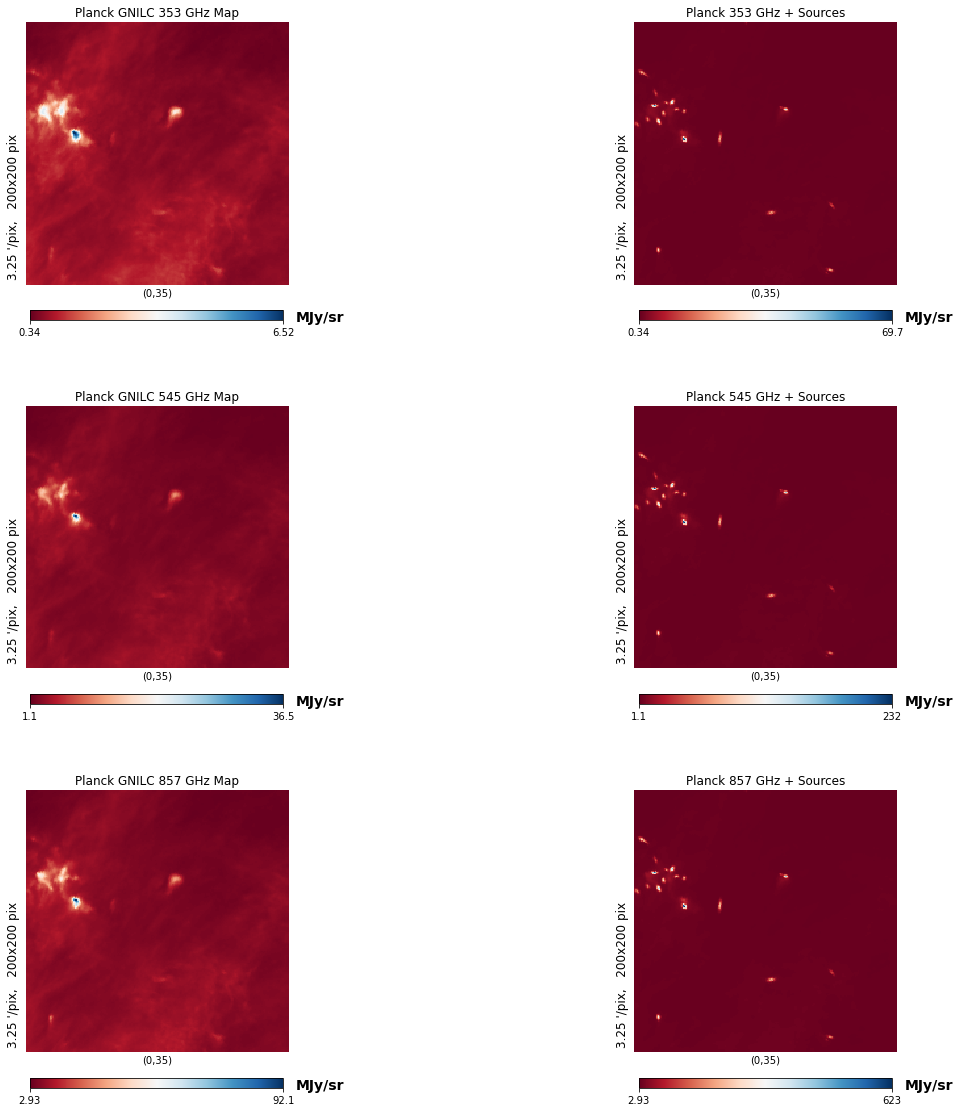

In [5]:
rot = [0, 35]
reso = 3.25
xsize = ysize = 200

if Beam == True:
    beam = " with beam smoothing"
else:
    beam = ""

gs = gridspec.GridSpec(3, 2)
plt.figure(figsize = (20, 20))
ax = plt.subplot(gs[0, 0])
hp.gnomview(gnilc_map_353, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck GNILC 353 GHz Map', unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 1])
hp.gnomview(combined_gnilcmap_353, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck 353 GHz + Sources' + beam, unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)

ax = plt.subplot(gs[1, 0])
hp.gnomview(gnilc_map_545, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck GNILC 545 GHz Map', unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 1])
hp.gnomview(combined_gnilcmap_545, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck 545 GHz + Sources' + beam, unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)

ax = plt.subplot(gs[2, 0])
hp.gnomview(gnilc_map_857, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck GNILC 857 GHz Map', unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[2, 1])
hp.gnomview(combined_gnilcmap_857, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck 857 GHz + Sources' + beam, unit = 'MJy/sr',
            cmap = 'RdBu', hold = True)

# Temperature and Beta Planck GNILC Maps with added PGCC sources
### Note no apparent correlation between sources and temperature or beta maps

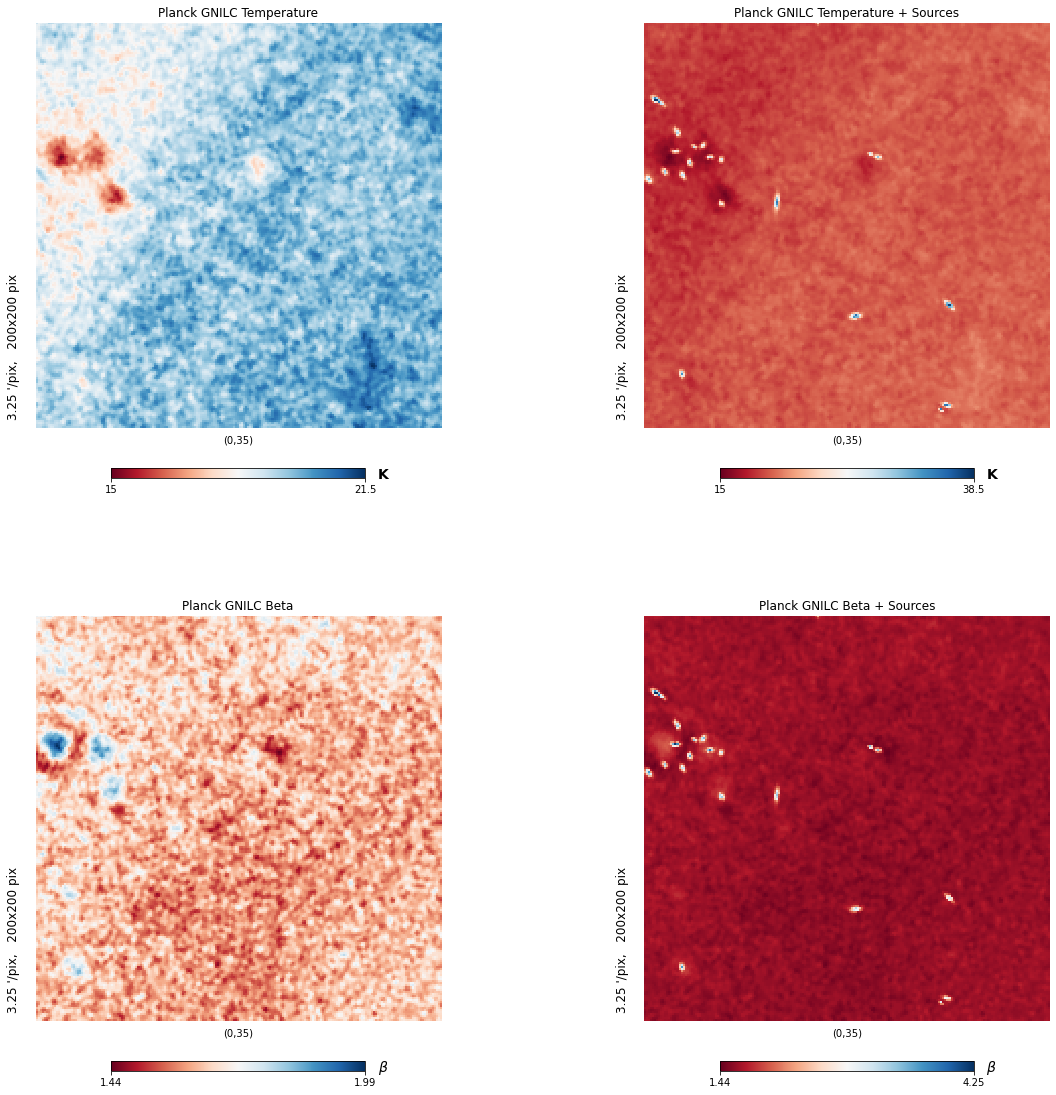

In [6]:
gs = gridspec.GridSpec(2, 2)
plt.figure(figsize = (20, 20))

ax = plt.subplot(gs[0, 0])
hp.gnomview(gnilc_dust_Td_nside2048, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck GNILC Temperature', unit = 'K',
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 1])
hp.gnomview(combined_gnilcmap_temp, rot = rot, reso = reso, xsize = xsize, ysize = ysize,
            title = 'Planck GNILC Temperature + Sources' + beam, unit = 'K',
            cmap = 'RdBu', hold = True)


ax = plt.subplot(gs[1, 0])
hp.gnomview(gnilc_dust_Bd_nside2048, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'Planck GNILC Beta', unit = '$\\beta$',
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 1])
hp.gnomview(combined_gnilcmap_beta, rot = rot, reso = reso, xsize = xsize, ysize = ysize,
            title = 'Planck GNILC Beta + Sources' + beam, unit = '$\\beta$', 
            cmap = 'RdBu', hold = True)

plt.savefig('temp_beta_Sources.jpg')

# Scaling Frequency Example: 
## From 353 GHz to 27 GHz

In [7]:
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")
units = u.uK_CMB

galccmap_27 = base_map.cold_clumps_flux(freq_out = 27, store_maps = False, output_units = units)

galccmap_39 = base_map.cold_clumps_flux(freq_out = 39, store_maps = False, output_units = units)

galccmap_93 = base_map.cold_clumps_flux(freq_out = 93, store_maps = False, output_units = units)

galccmap_145 = base_map.cold_clumps_flux(freq_out = 145, store_maps = False, output_units = units)

galccmap_225 = base_map.cold_clumps_flux(freq_out = 225, store_maps = False, output_units = units)

galccmap_280 = base_map.cold_clumps_flux(freq_out = 280, store_maps = False, output_units = units)

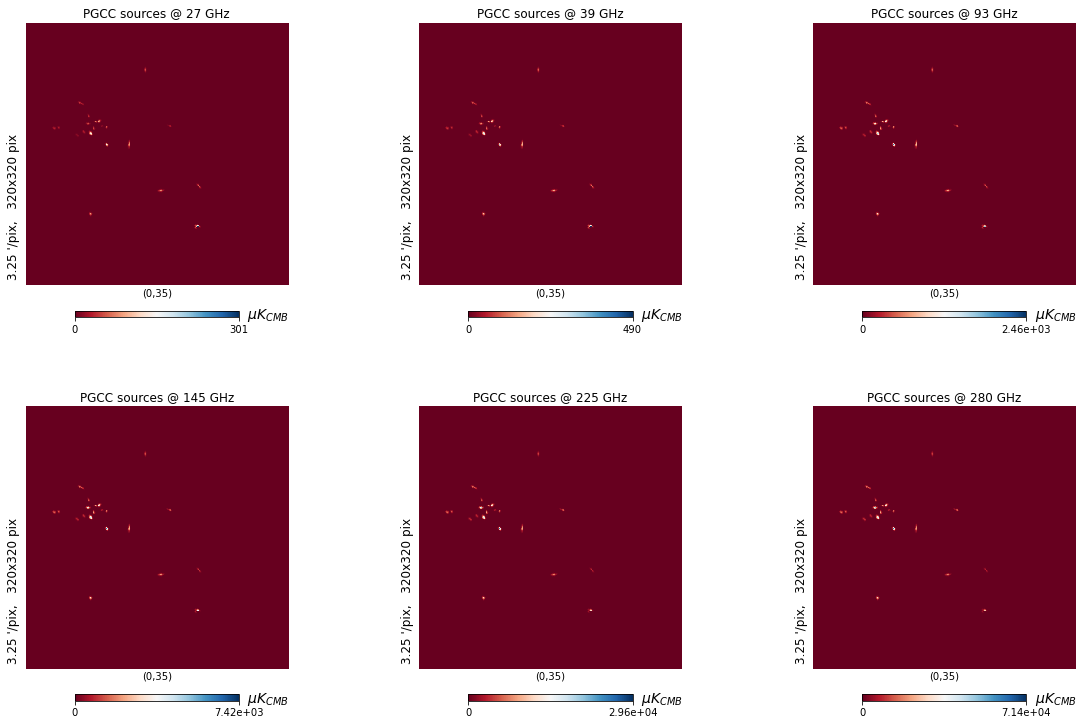

In [8]:
rot = [0, 35]
reso = 3.25
xsize = ysize = 320
gs = gridspec.GridSpec(3, 3)
plt.figure(figsize = (20, 20))
unit_label = "$\\mu K_{CMB}$"
                #"MJy / sr"

ax = plt.subplot(gs[0, 0])
hp.gnomview(galccmap_27, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 27 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 1])
hp.gnomview(galccmap_39, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 39 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 2])
hp.gnomview(galccmap_93, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 93 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 0])
hp.gnomview(galccmap_145, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 145 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 1])
hp.gnomview(galccmap_225, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 225 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 2])
hp.gnomview(galccmap_280, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 280 GHz', unit = unit_label, cmap = 'RdBu', hold = True)

# Mask Sources

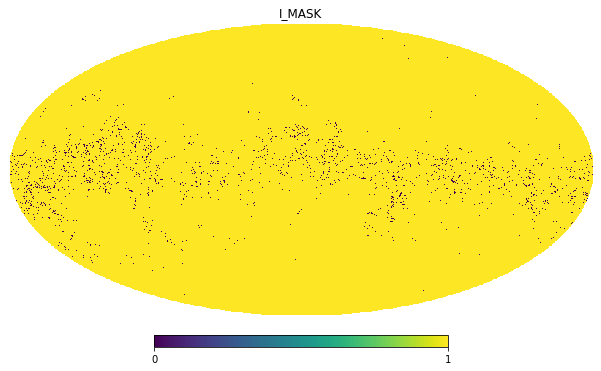

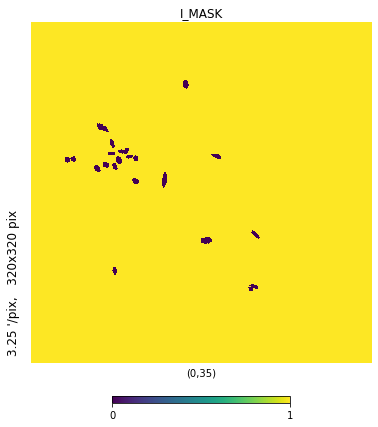

In [9]:
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")

source_mask = base_map.mask_sources()
hp.mollview(source_mask, title = 'I_MASK')
hp.gnomview(source_mask, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'I_MASK')